# Pràctica 4 PLH - Rubén Álvarez Aragonés i Pol Pérez Prades

____

## Imports 

In [ ]:
%pip install -r requirements.txt

In [1]:
import tensorflow as tf
import numpy as np
import nltk
import re
import spacy
from spacy.lang.ca.examples import sentences 
from gensim.models import word2vec
import torch
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Requisites
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import numpy as np


nltk.download('punkt')
nltk.download('stopwords')

spacy.cli.download("ca_core_news_sm")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ralva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ralva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Entrenament model Word2Vec

In [2]:
class Word2VecEmbedder:
    def __init__(self, corpus_path, corpus_size, load_model=False, model_path=None):
        if not load_model:
            self.corpus_path = corpus_path
            self.corpus_size = int(corpus_size * 2**30)  # Convert GB to bytes
            self.corpus = self.get_corpus(corpus_path)
            self.model = self.fit()
        else:
            try:
                self.load(model_path)
            except FileNotFoundError:
                print("Model not found. Please check the path.")
                return

    def get_corpus(self, corpus_path):
        with open(corpus_path, 'r', encoding='utf-8') as f:
            print("Reading corpus...")
            corpus = f.read(self.corpus_size)
            print("Preprocessing corpus...")
            corpus = self.preprocess(corpus)  # Preprocess the corpus and tokenize it
        return corpus

    def fit(self, window_size=15, vector_size=300, min_count=10, workers=8, epochs=10):
        # Initialize the Word2Vec model with gensim
        print("Initializing Word2Vec model...")
        self.model = word2vec.Word2Vec(sentences=self.corpus, vector_size=vector_size, window=window_size, min_count=min_count, workers=workers, epochs=epochs)
        print("Model training completed.")

        return self.model

    def save(self, model_path):
        # Save the model
        self.model.save(model_path)

    def load(self, model_path):
        # Load the model
        self.model = word2vec.Word2Vec.load(model_path)

    def preprocess(self, corpus):
        # Lowercase the corpus
        print("Lowercasing...")
        corpus = corpus.lower()
        
        # Remove special characters
        #print("Removing special characters...")
        #corpus = re.sub(r'[^a-záàéèíìóòúùñüç\s]', ' ', corpus)
        
        # Tokenize the corpus
        print("Tokenizing sentences...")
        corpus = nltk.sent_tokenize(corpus)
        
        print("Tokenizing words...")
        corpus = [nltk.word_tokenize(sentence) for sentence in corpus]
        
        # Remove last word of the last sentence if it is incomplete (or sentence if last sent is just one word)
        # corpus = corpus[len(corpus)-1][:-1] if len(corpus[-1]) == 1 else corpus[-1]

        return corpus

    def get_embedding(self, word):
        # Get the embedding of a word
        try:
            return self.model.wv[word]
        except KeyError:
            print(f"Word '{word}' not in vocabulary.")
            return None

    def print_vocab(self):
        print("Vocabulary:", list(self.model.wv.index_to_key))

Per tal de fer l'entrenament del model Word2Vec, hem generat aquesta classe que ens permetrà, de forma senzilla, entrenar el model amb les dades que tenim. Aquesta classe ens permetrà guardar el model en un fitxer per tal de no haver de tornar a entrenar-lo cada vegada que vulguem fer servir-lo. A més inclou mètodes per tal de fer servir el model d'una forma molt més natural.

El preprocessing de les dades és el següent:
- Lowercasing de les paraules
- Eliminació de caràcters especials (que es surten del llenguatge natural) (Finalment no s'ha fet aquest pas ja que al tenir un corpus tan gran aquest canvi generava paraules que no tenien sentit i per tant no aportava res positiu al model)
- Tokenització de les paraules
- Eliminació de les stopwords (Finalment no s'aplica el pas, ja que no són relevants, es triga més a entrenar el model i no aporta res positiu al model)

### 1. Model amb 100MB de dades

In [24]:
Word2Vec_model = Word2VecEmbedder('corpus\catalan_general_crawling.txt', 0.1)

Reading corpus...
Preprocessing corpus...
Lowercasing...
Removing special characters...
Tokenizing...
Initializing Word2Vec model...
Model training completed.


In [5]:
Word2Vec_model.save('models/word2vec_model.bin')

In [6]:
Word2Vec_model.print_vocab()

Vocabulary: ['de', 'la', 'i', 'a', 'que', 'el', 'l', 'en', 'd', 'per', 'els', 'del', 'les', 'un', 'amb', 'una', 'va', 'ha', 'no', 'al', 'es', 'és', 'més', 'com', 'dels', 's', 'aquest', 'hi', 'si', 'o', 'se', 'tot', 'aquesta', 'han', 'fer', 'molt', 'però', 'ser', 'també', 'ja', 'li', 'seu', 'als', 'seva', 'n', 'cap', 'seus', 't', 'ens', 'pàgina', 'veure', 'sobre', 'catalunya', 'pel', 'després', 'estat', 'ho', 'perquè', 'varen', 'entre', 'on', 'fet', 'et', 'català', 'havia', 'lleida', 'tots', 'quan', 'qui', 'són', 'ara', 'm', 'van', 'des', 'fins', 'hem', 'això', 'era', 'partit', 'dia', 'fa', 'anys', 'dir', 'sempre', 'diputació', 'barcelona', 'què', 'part', 'altres', 'només', 'contra', 'durant', 'dos', 'sense', 'equip', 'any', 'voltants', 'interessa', 'recomanem', 'informació', 'primer', 'col', 'em', 'visitis', 'lloc', 'gran', 'hitler', 'tant', 'restaurant', 'cada', 'ni', 'president', 'encara', 'persones', 'e', 'té', 'així', 'estan', 'pot', 'està', 'llengua', 'mateix', 'vam', 'grup', 'aqu

In [7]:
Word2Vec_model.get_embedding("de")

array([-6.78541362e-01,  5.39869368e-01,  4.03966844e-01, -2.98002988e-01,
        3.77685241e-02, -6.49072886e-01,  1.13005388e+00,  2.64642787e+00,
        3.80026370e-01, -1.04509163e+00,  1.03648722e+00, -7.91770697e-01,
       -5.02870560e-01,  1.77563763e+00, -3.65493208e-01, -9.19002369e-02,
        8.21657002e-01,  6.21918738e-01, -2.37203926e-01, -1.98278868e+00,
        1.44154593e-01,  1.57724953e+00,  6.22737229e-01,  3.83101165e-01,
        4.17130500e-01,  7.41416931e-01,  6.66761875e-01,  4.43641275e-01,
       -2.34811790e-02, -1.18666637e+00,  4.22608882e-01, -3.85012984e-01,
        6.69768685e-03,  1.61847115e+00,  1.04314852e+00,  1.14948690e+00,
        1.10098040e+00, -3.70280504e-01,  1.27088404e+00,  1.04942369e+00,
       -2.46912226e-01, -3.05297613e-01,  7.34553635e-02, -1.76460469e+00,
        2.44311619e+00,  9.74084020e-01, -4.06426102e-01,  5.44636071e-01,
       -3.31721753e-01,  1.94776249e+00, -9.34404135e-01,  3.40923250e-01,
       -1.15695894e+00,  

In [8]:
Word2Vec_model.model.wv.most_similar("negre")

[('sabons', 0.22556228935718536),
 ('madero', 0.22364427149295807),
 ('defectius', 0.21694914996623993),
 ('desviar', 0.21588577330112457),
 ('creixi', 0.21561698615550995),
 ('abatuda', 0.20904815196990967),
 ('exempt', 0.20841456949710846),
 ('estalviar', 0.2059682458639145),
 ('esotèrics', 0.19971071183681488),
 ('israelianes', 0.19927068054676056)]

### 2. Model amb 500MB de dades

In [92]:
Word2Vec_model_500 = Word2VecEmbedder('corpus\catalan_general_crawling.txt', 0.5)

Reading corpus...
Preprocessing corpus...
Lowercasing...
Removing special characters...
Tokenizing...
Initializing Word2Vec model...
Model training completed.


In [93]:
Word2Vec_model_500.get_embedding("hola")

array([-1.0367036e-04,  3.1121082e-03, -4.8848666e-04, -2.7847055e-03,
        3.1727559e-03, -2.1603017e-03, -6.2400621e-04, -2.9890386e-03,
       -2.6556973e-03,  1.9902149e-03,  1.7317823e-03,  2.3105880e-03,
       -1.1502433e-03,  5.4041186e-04, -1.3475545e-03,  1.8172733e-03,
        1.6352236e-03,  5.2921334e-04, -1.9406104e-03,  2.4403664e-03,
        2.5445588e-03, -2.7511776e-03, -3.7915827e-04,  1.1952475e-03,
        2.6584167e-03,  3.3016563e-03,  2.5468504e-03,  1.5089902e-03,
        1.1219601e-03,  2.8977832e-03,  2.0210266e-04, -2.8241591e-03,
        2.6366890e-03, -7.9594611e-04, -2.7691608e-03, -2.5309348e-03,
        4.7770023e-04, -2.4588986e-03, -1.5773411e-03, -4.0856082e-04,
        1.4568691e-03,  2.3083154e-03, -9.3776465e-04, -1.6760667e-03,
        1.1046369e-03,  5.1194627e-04,  3.1526459e-03,  1.0326914e-03,
       -2.7082399e-03, -2.1520734e-03,  2.2663327e-03, -2.8479516e-03,
       -1.6272847e-03,  8.9176378e-04, -2.6377186e-03, -1.2163027e-03,
      

### 3. Model amb 1GB de dades

In [ ]:
Word2Vec_model_1024 = Word2VecEmbedder('corpus\catalan_general_crawling.txt', 1)

In [ ]:
Word2Vec_model_1024.get_embedding("hola")

### 4. Model amb totes les dades

In [ ]:
Word2Vec_model_full_data = Word2VecEmbedder('corpus\catalan_general_crawling.txt', None)

In [ ]:
Word2Vec_model_full_data.get_embedding("hola")

## Entrenament model de Similitud de Text Semàntic

### Imports

In [3]:
from importació_data import read_all_ts_data, reformat_data, create_corpus, preprocess, flattened_corpus_count, stopwords_cat
from importació_data import pair_list_to_x_y
from model_bàsic import build_and_compile_model_better
import tensorflow as tf
from model_bàsic import compute_pearson

Definim les stopwords del català i la funció del preprocessament del text, que les tindrà en compte a la hora de tokenitzar i natejar el text.

In [11]:
stpw_cat = stopwords_cat()
prepro = lambda x: preprocess(x, stpw_cat)

Per altra banda, llegim les dades i definim les variables més importants per a la creació dels models de similitud de text semàntic.
- Llegim totes les dades de text similarity dividint-les en train, test i val. 
- Reformatejem les dades per a que siguin l'estructura List[Tuple[str, str, float]]. 
- Definim el corpus i el diccionari amb totes les paraules.
- Creem un diccionari de python amb tots els indexs com a claus i amb la repetició de les paraules com a valor.

In [12]:
train, test, val = read_all_ts_data()
train, test, val = reformat_data(train, test, val)
corpus, dictionary = create_corpus(train, test, val, preprocess=prepro)
flat_corpus = flattened_corpus_count(corpus)

### Compartació amb diferents models de Word Embeddings

#### 1. One Hot

In [25]:
from onehot import map_one_hot

Un embedding OneHot té tamany igual a la llargada del diccionari. En la importació de dades ja hem eliminat les stopwords per reduïr la dimensió, però ara també eliminarem del embedding aquelles paraules que es repeteixen masses poques vegades o massa sovint. 

Per aconseguir això creem una llista que conté els indexs de les paraules que sí que utilitzarem i la passem com a argument a la funció *map_one_hot()*, per reduïr la dimensió del embedding.

In [26]:
# Eliminate from the dictionary the words that are repeated very few times or too many times
keys_preprocess = [index  for index in dictionary if flat_corpus[index] > 10 and flat_corpus[index] < 50]

Convertim les paraules a vectors OneHot amb la funció *map_one_hot()*. Aquesta funció crea un vector de zeros de la mida del diccionari i posa un 1 a la posició de la paraula en el diccionari.

In [27]:
mapped_one_hot_train = map_one_hot(train, dictionary, keys_preprocess)
mapped_one_hot_test = map_one_hot(test, dictionary, keys_preprocess)
mapped_one_hot_val = map_one_hot(val, dictionary, keys_preprocess)

Separem el X i Y

In [28]:
x_train_oh, y_train_oh = pair_list_to_x_y(mapped_one_hot_train)
x_val_oh, y_val_oh = pair_list_to_x_y(mapped_one_hot_val)
x_test_oh, y_test_oh = pair_list_to_x_y(mapped_one_hot_test)

Entrenem el model

In [29]:
batch_size_oh: int = 64
num_epochs_oh: int = 64

train_dataset_oh = tf.data.Dataset.from_tensor_slices((x_train_oh, y_train_oh))
train_dataset_oh = train_dataset_oh.shuffle(buffer_size=len(x_train_oh)).batch(batch_size_oh)

val_dataset_oh = tf.data.Dataset.from_tensor_slices((x_val_oh, y_val_oh))
val_dataset_oh = val_dataset_oh.batch(batch_size_oh)

In [30]:
embedding_size_oh = len(keys_preprocess)
model_oh = build_and_compile_model_better(embedding_size = embedding_size_oh)
tf.keras.utils.plot_model(model_oh, show_shapes=True, show_layer_activations=True, )
print(model_oh.summary())

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 801)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 801)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 801)       │    642,402 │ input_layer_6[0]… │
│                     │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 801)       │          0 │ dense_8[0][0],    │
│                     │                   │            │ dense_8[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 801)       │          0 │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │     12,832 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 16)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         17 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1)         │          0 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 655,251 (2.50 MB)

 Trainable params: 655,251 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
model_oh.fit(train_dataset_oh, epochs=num_epochs_oh, validation_data=val_dataset_oh)

Epoch 1/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7401 - val_loss: 0.7530
Epoch 2/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7243 - val_loss: 0.7474
Epoch 3/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7156 - val_loss: 0.7449
Epoch 4/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7045 - val_loss: 0.7398
Epoch 5/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6766 - val_loss: 0.7285
Epoch 6/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6062 - val_loss: 0.7252
Epoch 7/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4972 - val_loss: 0.7408
Epoch 8/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3936 - val_loss: 0.7610
Epoch 9/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3139 - val_loss: 0.7777
Epoch 10/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2588 - val_loss: 0.7889
Epoch 11/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2256 - val_loss: 0.7939
Epoch 12/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1974 - val_l

Evaluem el model amb la partició de validació

In [32]:
print(f"Correlación de Pearson (train): {compute_pearson(model_oh, x_train_oh, y_train_oh)}")
print(f"Correlación de Pearson (validation): {compute_pearson(model_oh, x_val_oh, y_val_oh)}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correlación de Pearson (train): 0.9559864418741453
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Correlación de Pearson (validation): 0.17231757121240085


Provem el model amb la partició de test

In [33]:
print(f"Correlación de Pearson (test): {compute_pearson(model_oh, x_test_oh, y_test_oh)}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Correlación de Pearson (test): 0.2313645187854227


##### Conclusions de One-hot

Com podem observar a la hora de fer l'entrenament, el model fa molt *overfit*, així que no és capaç de generalitzar bé. Això és degut a que el model OneHot no té en compte la semàntica de les paraules, ja que cada paraula és tractada com a un element únic i no es té en compte el context en el que apareixen les paraules. Una altra raó per la que el model OneHot no és bó és perquè la mida dels vectors és molt gran, ja que la mida dels vectors és igual a la mida del diccionari, i això fa que el model sigui molt ineficient.

#### 2. Word2Vec preentrenats 

In [4]:
from word2vec_tf_idf import map_pairs_w2v

Llegim el model de Word2Vec preentrenat en català.

In [5]:
WORD_EMBEDDING_FILE = "C:/Users/ralva/Downloads/cc.ca.300.bin.gz"


USE_MMAP = False
if USE_MMAP:
    from gensim.models.fasttext import FastTextKeyedVectors
    MMAP_PATH = 'cc.ca.300.bin'
    # wv_model.save(MMAP_PATH)
    wv_model = FastTextKeyedVectors.load(MMAP_PATH, mmap='r')
else:
    from gensim.models import fasttext
    wv_model = fasttext.load_facebook_vectors(WORD_EMBEDDING_FILE)

##### 2.1 Mitjana

Convertim a vectors les frases amb la funció *map_w2v()*. Aquesta funció obté l'embedding de Word2Vec de cada paraula de la frase i en fa la mitjana.

In [34]:
mapped_w2v_mean_train = map_pairs_w2v(train, wv_model, dictionary=dictionary, preprocess=prepro)
mapped_w2v_mean_test = map_pairs_w2v(test, wv_model, dictionary=dictionary, preprocess=prepro)
mapped_w2v_mean_val = map_pairs_w2v(val, wv_model, dictionary=dictionary, preprocess=prepro)

Separem les dades en X i Y.

In [35]:
x_train_w2v_mean, y_train_w2v_mean = pair_list_to_x_y(mapped_w2v_mean_train)
x_val_w2v_mean, y_val_w2v_mean = pair_list_to_x_y(mapped_w2v_mean_val)
x_test_w2v_mean, y_test_w2v_mean = pair_list_to_x_y(mapped_w2v_mean_test)

Entrenem el model

In [36]:
batch_size_w2v_mean: int = 64
num_epochs_w2v_mean: int = 64

train_dataset_w2v_mean = tf.data.Dataset.from_tensor_slices((x_train_w2v_mean, y_train_w2v_mean))
train_dataset_w2v_mean = train_dataset_w2v_mean.shuffle(buffer_size=len(x_train_w2v_mean)).batch(batch_size_w2v_mean)

val_dataset_w2v_mean = tf.data.Dataset.from_tensor_slices((x_val_w2v_mean, y_val_w2v_mean))
val_dataset_w2v_mean = val_dataset_w2v_mean.batch(batch_size_w2v_mean)

In [37]:
embedding_size_w2v_mean = 300
model_w2v_mean = build_and_compile_model_better(embedding_size = embedding_size_w2v_mean)
tf.keras.utils.plot_model(model_w2v_mean, show_shapes=True, show_layer_activations=True)
print(model_w2v_mean.summary())

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 300)       │     90,300 │ input_layer_8[0]… │
│                     │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 300)       │          0 │ dense_11[0][0],   │
│                     │                   │            │ dense_11[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 300)       │          0 │ lambda_6[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 16)        │      4,816 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 16)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         17 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1)         │          0 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,133 (371.61 KB)

 Trainable params: 95,133 (371.61 KB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
model_w2v_mean.fit(train_dataset_w2v_mean, epochs=num_epochs_w2v_mean, validation_data=val_dataset_w2v_mean)

Epoch 1/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7261 - val_loss: 0.7343
Epoch 2/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7113 - val_loss: 0.7171
Epoch 3/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6906 - val_loss: 0.6949
Epoch 4/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6620 - val_loss: 0.6754
Epoch 5/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6131 - val_loss: 0.6588
Epoch 6/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5565 - val_loss: 0.6487
Epoch 7/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4861 - val_loss: 0.6309
Epoch 8/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4185 - val_loss: 0.6246
Epoch 9/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3426 - val_loss: 0.6153
Epoch 10/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2768 - val_loss: 0.6116
Epoch 11/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381 - val_loss: 0.6138
Epoch 12/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2041 - val_lo

Evaluem el model amb la partició de validació

In [39]:
print(f"Correlación de Pearson (train): {compute_pearson(model_w2v_mean, x_train_w2v_mean, y_train_w2v_mean)}")
print(f"Correlación de Pearson (validation): {compute_pearson(model_w2v_mean, x_val_w2v_mean, y_val_w2v_mean)}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correlación de Pearson (train): 0.9778792200325723
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Correlación de Pearson (validation): 0.4105741836185312


Provem el model amb la partició de test

In [40]:
print(f"Correlación de Pearson (test): {compute_pearson(model_w2v_mean, x_test_w2v_mean, y_test_w2v_mean)}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Correlación de Pearson (test): 0.3287821801666412


##### Conclusions de vectors preentrenats amb mitjana

Podem observar com amb el model Word2vec i la mitjana el model segueix fent sobreajust però funciona molt millor que el OneHot. Això és degut a que el model Word2Vec té en compte la semàntica de les paraules, ja que les paraules que tenen un significat similar tenen un embedding similar. Això fa que el model sigui capaç de generalitzar millor.

##### 2.2 Tf-idf

Definim el model de Tf-idf amb el corpus definit al inici.

In [41]:
from gensim.models import TfidfModel
modelo_tfidf = TfidfModel(corpus)

Fent servir la funció *map_w2v_tfidf()* s'obté l'embedding de Word2Vec de cada paraula de la frase i s'aplica Tf-idf per obtenir un vector de la frase.

In [42]:
mapped_w2v_tfidf_train = map_pairs_w2v(train, wv_model, dictionary=dictionary,tf_idf_model=modelo_tfidf, preprocess=prepro)
mapped_w2v_tfidf_test = map_pairs_w2v(test, wv_model, dictionary=dictionary,tf_idf_model=modelo_tfidf, preprocess=prepro)
mapped_w2v_tfidf_val = map_pairs_w2v(val, wv_model, dictionary=dictionary,tf_idf_model=modelo_tfidf, preprocess=prepro)

Separem les dades en X i Y.

In [43]:
x_train_w2v_tfidf, y_train_w2v_tfidf = pair_list_to_x_y(mapped_w2v_tfidf_train)
x_val_w2v_tfidf, y_val_w2v_tfidf = pair_list_to_x_y(mapped_w2v_tfidf_val)
x_test_w2v_tfidf, y_test_w2v_tfidf = pair_list_to_x_y(mapped_w2v_tfidf_test)

Entrenem el model

In [44]:
batch_size_w2v_tfidf: int = 64
num_epochs_w2v_tfidf: int = 64

train_dataset_w2v_tfidf = tf.data.Dataset.from_tensor_slices((x_train_w2v_tfidf, y_train_w2v_tfidf))
train_dataset_w2v_tfidf = train_dataset_w2v_tfidf.shuffle(buffer_size=len(x_train_w2v_tfidf)).batch(batch_size_w2v_tfidf)

val_dataset_w2v_tfidf = tf.data.Dataset.from_tensor_slices((x_val_w2v_tfidf, y_val_w2v_tfidf))
val_dataset_w2v_tfidf = val_dataset_w2v_tfidf.batch(batch_size_w2v_tfidf)

In [45]:
embedding_size_w2v_tfidf = 300
model_w2v_tfidf = build_and_compile_model_better(embedding_size = embedding_size_w2v_tfidf)
tf.keras.utils.plot_model(model_w2v_tfidf, show_shapes=True, show_layer_activations=True)
print(model_w2v_tfidf.summary())

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 300)       │     90,300 │ input_layer_10[0… │
│                     │                   │            │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 300)       │          0 │ dense_14[0][0],   │
│                     │                   │            │ dense_14[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 300)       │          0 │ lambda_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 16)        │      4,816 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 16)        │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         17 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 1)         │          0 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,133 (371.61 KB)

 Trainable params: 95,133 (371.61 KB)

 Non-trainable params: 0 (0.00 B)

None


In [46]:
model_w2v_tfidf.fit(train_dataset_w2v_tfidf, epochs=num_epochs_w2v_tfidf, validation_data=val_dataset_w2v_tfidf)

Epoch 1/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7248 - val_loss: 0.7314
Epoch 2/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7043 - val_loss: 0.7112
Epoch 3/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6787 - val_loss: 0.6896
Epoch 4/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6425 - val_loss: 0.6725
Epoch 5/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5924 - val_loss: 0.6537
Epoch 6/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5168 - val_loss: 0.6373
Epoch 7/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4373 - val_loss: 0.6232
Epoch 8/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3541 - val_loss: 0.6110
Epoch 9/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2987 - val_loss: 0.6043
Epoch 10/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2203 - val_loss: 0.6056
Epoch 11/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1885 - val_loss: 0.6071
Epoch 12/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1643 - val_lo

Evaluem el model amb la partició de validació

In [47]:
print(f"Correlación de Pearson (train): {compute_pearson(model_w2v_tfidf, x_train_w2v_tfidf, y_train_w2v_tfidf)}")
print(f"Correlación de Pearson (validation): {compute_pearson(model_w2v_tfidf, x_val_w2v_tfidf, y_val_w2v_tfidf)}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Correlación de Pearson (train): 0.9839335858168407
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Correlación de Pearson (validation): 0.4417986700290855


Provem el model amb la partició de test

In [48]:
print(f"Correlación de Pearson (test): {compute_pearson(model_w2v_tfidf, x_test_w2v_tfidf, y_test_w2v_tfidf)}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Correlación de Pearson (test): 0.3993768299305017


##### Conclusions vectors preentrenats amb Tf-idf

Podem observar com, fent us de Tf-idf, el model millora una mica més. Això és degut a que Tf-idf té en compte la freqüència de les paraules en el corpus, i això fa que les paraules que apareixen molt sovint tinguin un pes més baix. Això fa que el model sigui capaç de generalitzar millor. Tot i així el model segueix sobreajustant

#### 3. SpaCy

Importem tot allò necessari per a fer servir el model de SpaCy en català, inclòs el model preentrenat.

In [49]:
import spacy
from spacy_embed import map_spacy_embed

In [50]:
!python -m spacy download ca_core_news_md

     ---------------------------------------- 0.0/49.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/49.2 MB ? eta -:--:--
     --------------------------------------- 0.1/49.2 MB 812.7 kB/s eta 0:01:01
     ---------------------------------------- 0.4/49.2 MB 3.2 MB/s eta 0:00:16
      --------------------------------------- 0.9/49.2 MB 4.9 MB/s eta 0:00:10
     - -------------------------------------- 1.4/49.2 MB 6.5 MB/s eta 0:00:08
     - -------------------------------------- 2.1/49.2 MB 7.7 MB/s eta 0:00:07
     -- ------------------------------------- 2.8/49.2 MB 8.9 MB/s eta 0:00:06
     --- ------------------------------------ 3.8/49.2 MB 10.6 MB/s eta 0:00:05
     ---- ----------------------------------- 5.0/49.2 MB 12.2 MB/s eta 0:00:04
     ----- ---------------------------------- 6.4/49.2 MB 14.2 MB/s eta 0:00:04
     ------ --------------------------------- 8.0/49.2 MB 16.6 MB/s eta 0:00:03
     ------- ------------------------------- 10.1/49.2 MB 19.

Carreguem el model de SpaCy en català.

In [51]:
spacy_model = spacy.load("ca_core_news_md")

c:\Users\ralva\Desktop\University\4t-Cuatrimestre-GIA\PLH\PLH-WordEmbeddings\WordEmbeddings\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Passem les particions de train, test i val a vectors amb la funció *map_spacy()*. Aquesta funció utilitza el model de SpaCy per a convertir les frases a vectors.

In [52]:
mapped_spacy_train = map_spacy_embed(train, spacy_model)
mapped_spacy_test = map_spacy_embed(test, spacy_model)
mapped_spacy_val = map_spacy_embed(val, spacy_model)

Dividim les particions en X i Y.

In [53]:
x_train_sp, y_train_sp = pair_list_to_x_y(mapped_spacy_train)
x_val_sp, y_val_sp = pair_list_to_x_y(mapped_spacy_val)
x_test_sp, y_test_sp = pair_list_to_x_y(mapped_spacy_test)

Entrenem el model

In [54]:
batch_size_sp: int = 64
num_epochs_sp: int = 64

train_dataset_sp = tf.data.Dataset.from_tensor_slices((x_train_sp, y_train_sp))
train_dataset_sp = train_dataset_sp.shuffle(buffer_size=len(x_train_sp)).batch(batch_size_sp)

val_dataset_sp = tf.data.Dataset.from_tensor_slices((x_val_sp, y_val_sp))
val_dataset_sp = val_dataset_sp.batch(batch_size_sp)

In [55]:
embedding_size_sp = 300
model_sp = build_and_compile_model_better(embedding_size = embedding_size_sp)
tf.keras.utils.plot_model(model_sp, show_shapes=True, show_layer_activations=True, )
print(model_sp.summary())

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 300)       │     90,300 │ input_layer_12[0… │
│                     │                   │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 300)       │          0 │ dense_17[0][0],   │
│                     │                   │            │ dense_17[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 300)       │          0 │ lambda_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 16)        │      4,816 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 16)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         17 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 1)         │          0 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,133 (371.61 KB)

 Trainable params: 95,133 (371.61 KB)

 Non-trainable params: 0 (0.00 B)

None


In [56]:
model_sp.fit(train_dataset_sp, epochs=num_epochs_sp, validation_data=val_dataset_sp)

Epoch 1/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7224 - val_loss: 0.7355
Epoch 2/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7090 - val_loss: 0.7266
Epoch 3/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6928 - val_loss: 0.7164
Epoch 4/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6742 - val_loss: 0.7061
Epoch 5/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6554 - val_loss: 0.6980
Epoch 6/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6258 - val_loss: 0.6875
Epoch 7/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6001 - val_loss: 0.6789
Epoch 8/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5723 - val_loss: 0.6648
Epoch 9/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5450 - val_loss: 0.6583
Epoch 10/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5122 - val_loss: 0.6529
Epoch 11/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4778 - val_loss: 0.6400
Epoch 12/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4449 - val_lo

Evaluem el model amb al partició de validation

In [57]:
print(f"Correlación de Pearson (train): {compute_pearson(model_sp, x_train_sp, y_train_sp)}")
print(f"Correlación de Pearson (validation): {compute_pearson(model_sp, x_val_sp, y_val_sp)}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correlación de Pearson (train): 0.9427128328716075
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Correlación de Pearson (validation): 0.2946724396020136


Provem el model amb la partició de test

In [58]:
print(f"Correlación de Pearson (train): {compute_pearson(model_sp, x_test_sp, y_test_sp)}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Correlación de Pearson (train): 0.23983454885994035


##### Conclusions de SpaCy

Utilitzant el model de SpaCy, el model segueix fent sobreajust, i funciona de manera molt similar al Word2Vec, però una mica pitjor. Això és degut a que el model de SpaCy també té en compte la semàntica de les paraules, ja que les paraules que tenen un significat similar tenen un embedding similar. Això fa que el model sigui capaç de generalitzar millor.

#### 4. RoBERTa 

In [59]:
from roberta_base import map_roberta_embed
import spacy

In [60]:
!python -m spacy download ca_core_news_trf

     ---------------------------------------- 0.0/457.1 MB ? eta -:--:--
     -------------------------------------- 0.0/457.1 MB 682.7 kB/s eta 0:11:10
     ---------------------------------------- 0.1/457.1 MB 1.1 MB/s eta 0:07:16
     ---------------------------------------- 0.4/457.1 MB 3.1 MB/s eta 0:02:27
     ---------------------------------------- 0.9/457.1 MB 5.3 MB/s eta 0:01:27
     ---------------------------------------- 1.5/457.1 MB 6.8 MB/s eta 0:01:08
     ---------------------------------------- 2.2/457.1 MB 8.2 MB/s eta 0:00:56
     ---------------------------------------- 2.9/457.1 MB 9.4 MB/s eta 0:00:49
     --------------------------------------- 4.0/457.1 MB 11.0 MB/s eta 0:00:42
     --------------------------------------- 5.1/457.1 MB 12.6 MB/s eta 0:00:36
      -------------------------------------- 6.6/457.1 MB 14.6 MB/s eta 0:00:31
      -------------------------------------- 8.4/457.1 MB 16.7 MB/s eta 0:00:27
      ------------------------------------- 10.

Carreguem el model de RoBERTa preentrenat en català.

In [61]:
roberta_model = spacy.load("ca_core_news_trf")

Passem les particions de train, test i val a vectors amb la funció *map_roberta()*. Aquesta funció utilitza el model de RoBERTa per a convertir les frases a vectors.

Per estalviar temps d'execució, només s'entrena el model que fa servir mean en comptes del cls token.

Com es troba a la documentació, si es vol fer servir el model amb el cls token, s'ha de canviar el boolean de cls a True a la següent funció.

In [62]:
mapped_roberta_train = map_roberta_embed(train, roberta_model, cls = False)
mapped_roberta_test = map_roberta_embed(test, roberta_model, cls = False)
mapped_roberta_val = map_roberta_embed(val, roberta_model, cls = False)

Dividim les particions en X i Y.

In [63]:
x_train_roberta, y_train_roberta = pair_list_to_x_y(mapped_roberta_train)
x_val_roberta, y_val_roberta = pair_list_to_x_y(mapped_roberta_val)
x_test_roberta, y_test_roberta = pair_list_to_x_y(mapped_roberta_test)

Entrenem el model.

In [64]:
batch_size_roberta: int = 64
num_epochs_roberta: int = 64

train_dataset_roberta = tf.data.Dataset.from_tensor_slices((x_train_roberta, y_train_roberta))
train_dataset_roberta = train_dataset_roberta.shuffle(buffer_size=len(x_train_roberta)).batch(batch_size_roberta)

val_dataset_roberta = tf.data.Dataset.from_tensor_slices((x_val_roberta, y_val_roberta))
val_dataset_roberta = val_dataset_roberta.batch(batch_size_roberta)

In [65]:
embedding_size_roberta = 768
model_roberta = build_and_compile_model_better(embedding_size = embedding_size_roberta)
tf.keras.utils.plot_model(model_roberta, show_shapes=True, show_layer_activations=True)
print(model_roberta.summary())

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 768)       │    590,592 │ input_layer_14[0… │
│                     │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 768)       │          0 │ dense_20[0][0],   │
│                     │                   │            │ dense_20[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 768)       │          0 │ lambda_12[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 16)        │     12,304 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 16)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │         17 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 1)         │          0 │ dense_22[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 602,913 (2.30 MB)

 Trainable params: 602,913 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

None


In [66]:
model_roberta.fit(train_dataset_roberta, epochs=num_epochs_roberta, validation_data=val_dataset_roberta)

Epoch 1/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7239 - val_loss: 0.7363
Epoch 2/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7096 - val_loss: 0.7273
Epoch 3/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6947 - val_loss: 0.7130
Epoch 4/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6716 - val_loss: 0.6962
Epoch 5/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6380 - val_loss: 0.6877
Epoch 6/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6036 - val_loss: 0.6766
Epoch 7/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5665 - val_loss: 0.6651
Epoch 8/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5408 - val_loss: 0.6616
Epoch 9/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5071 - val_loss: 0.6483
Epoch 10/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4759 - val_loss: 0.6365
Epoch 11/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4563 - val_loss: 0.6300
Epoch 12/64
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4167 - val_lo

Evaluar el model amb la partició de validació.

In [67]:
print(f"Correlación de Pearson (train): {compute_pearson(model_roberta, x_train_roberta, y_train_roberta)}")
print(f"Correlación de Pearson (validation): {compute_pearson(model_roberta, x_val_roberta, y_val_roberta)}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correlación de Pearson (train): 0.9591333703501492
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Correlación de Pearson (validation): 0.4765784093836927


Provar el model amb la partició de test.

In [68]:
print(f"Correlación de Pearson (test): {compute_pearson(model_roberta, x_test_roberta, y_test_roberta)}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Correlación de Pearson (test): 0.2913739403941077


##### Conclusions Roberta

Veiem com el model de RoBERTa és un dels que millor funciona, ja que és el model més avançat i el que millor semàntica té. Això fa que el model sigui capaç de generalitzar millor.
Per altra banda, els seus vectors són més grans així que és més pesat d'executar que els altres models.

Si comparem els resultats de fer servir cls o mean, veiem com mean funciona millor gairebé en tots els casos. Creiem que això és degut a que mean té en compte totes les paraules de la frase, mentre que cls només té en compte una. Això fa que mean sigui capaç de captar millor la semàntica de la frase.

#### 5. RoBERTa fine-tuned

Instal·lem les llibreries necessàries

In [69]:
%pip install tf-keras
%pip install transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Fem els imports de les funcions.

In [70]:
from roberta_fine_tuned import prepare_roberta_ft, compute_pearson_roberta_ft, x_y_split_roberta_ft
from transformers import pipeline, AutoTokenizer

Creem el model de RoBERTa fine-tuned.

In [71]:
model_roberta_ft = 'projecte-aina/roberta-base-ca-v2-cased-sts'
tokenizer_roberta_ft = AutoTokenizer.from_pretrained(model_roberta_ft)
pipe_roberta_ft = pipeline('text-classification', model=model_roberta_ft, tokenizer=tokenizer_roberta_ft)

Separem en X i Y.

In [72]:
X_train_roberta_ft, y_train_roberta_ft = x_y_split_roberta_ft(train)
X_val_roberta_ft, y_val_roberta_ft = x_y_split_roberta_ft(val)
X_test_roberta_ft, y_test_roberta_ft = x_y_split_roberta_ft(test)

In [73]:
X = X_train_roberta_ft + X_val_roberta_ft + X_test_roberta_ft
y = y_train_roberta_ft + y_val_roberta_ft + y_test_roberta_ft

Obtenim els resultats del model

In [74]:
predictions = pipe_roberta_ft(prepare_roberta_ft(X, tokenizer_roberta_ft), add_special_tokens=False)

In [87]:
print(f"Correlación de Pearson (all data): {compute_pearson_roberta_ft(predictions, y)}")
print(f"Correlación de Pearson (train): {compute_pearson_roberta_ft(predictions[:len(X_train_roberta_ft)], y_train_roberta_ft)}")
print(f"Correlación de Pearson (validation): {compute_pearson_roberta_ft(predictions[len(X_train_roberta_ft):len(X_train_roberta_ft) + len(X_val_roberta_ft)], y_val_roberta_ft)}")

Correlación de Pearson (all data): 0.890561552970006
Correlación de Pearson (train): 0.9469576863404018
Correlación de Pearson (validation): 0.7862732421909332


In [76]:
print(f"Correlación de Pearson (test): {compute_pearson_roberta_ft(predictions[-len(y_test_roberta_ft):], y_test_roberta_ft)}")

Correlación de Pearson (test): 0.7527686784730463


##### Conclusions Roberta fine-tuned

Sens dubte el model de RoBERTa fine-tuned és el que millor funciona, ja que és el model més avançat i el que millor semàntica té. Això fa que el model sigui capaç de generalitzar millor.

## Models amb embeddings entrenables

En aquesta secció ens hem trobat amb un problema a l'hora de fer servir les classes de la xarxa neuronal que se'ns proporcionaven. Després d'investigar hem vist que el problema era degut a que es feien servir funcions que esperen tensors de TensorFlow i realment el input era de Keras. Per això hem decidit aplicar certes modificacions al codi per tal de poder seguir endavant amb la pràctica.

Cal esmentar que després de comentar el problema amb certs companys, hem vist que no erem els únics que ens havíem trobat amb aquest problema. Tot i això moltes persones van fer servir Google Colab ja que sembla que no succeeix aquest error en aquesta plataforma. Per la nostra part, hem decidit seguir endavant amb les modificacions ja que ens semblava una bona oportunitat per aprendre més sobre les xarxes neuronals.

Un cop finalitzada la pràctica, hem vist que no hem sigut capaços de fer funcionar els models amb random embeddings (Després es comentarà més a fons). Per aquest motiu, suposem que hem fet una mala decisió a l'hora de fer els canvis al codi, potser hauríem d'haver fet servir Google Colab o haver investigat més a fons el problema. Amb una mica més de temps, segurament hauríem pogut solucionar el problema.

In [77]:
REMAP_EMBEDDINGS: bool = True
USE_PRETRAINED: bool = True
MAX_LEN: int = 96

In [78]:
from trainable_embed_model import map_w2v_trainable, model_2, pair_list_to_x_y

Passem les particions de train, test i val a vectors amb la funció *map_w2v_trainable()*. Aquesta funció utilitza el model de Word2Vec per a convertir les frases a vectors.

In [79]:
mapped_train_trainable = map_w2v_trainable(wv_model, train, MAX_LEN, dictionary)
mapped_test_trainable = map_w2v_trainable(wv_model, test, MAX_LEN, fixed_dictionary=dictionary)
mapped_val_trainable = map_w2v_trainable(wv_model, val, MAX_LEN, fixed_dictionary=dictionary)

Partim en X i Y.

In [80]:
x_train_trainable, y_train_trainable = pair_list_to_x_y(mapped_train_trainable)
x_val_trainable, y_val_trainable = pair_list_to_x_y(mapped_val_trainable)
x_test_trainable, y_test_trainable = pair_list_to_x_y(mapped_test_trainable)

Reformatejem les dades per a que siguin l'estructura correcte.

In [81]:
batch_size_trainable: int = 64
num_epochs_trainable: int = 128

train_dataset_trainable = tf.data.Dataset.from_tensor_slices((x_train_trainable, y_train_trainable))
train_dataset_trainable = train_dataset_trainable.shuffle(buffer_size=len(x_train_trainable)).batch(batch_size_trainable)

val_dataset_trainable = tf.data.Dataset.from_tensor_slices((x_val_trainable, y_val_trainable))
val_dataset_trainable = val_dataset_trainable.batch(batch_size_trainable)

### Random embeddings

Creem el model amb embeddings aleatoris, sense cap tipus de preentrenament.

In [82]:
model_random = model_2(MAX_LEN, pretrained_weights=None, trainable=False, use_cosine=False)
model_random.summary()

c:\Users\ralva\Desktop\University\4t-Cuatrimestre-GIA\PLH\PLH-WordEmbeddings\WordEmbeddings\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\ralva\Desktop\University\4t-Cuatrimestre-GIA\PLH\PLH-WordEmbeddings\WordEmbeddings\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'sequential_2' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 96)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 96)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 96, 16)    │     16,000 │ input_layer_16[0… │
│ (Embedding)         │                   │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 96)        │          0 │ input_layer_16[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_mask_4     │ (None, 96)        │          0 │ input_layer_16[0… │
│ (MyLayer_mask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 96)        │          0 │ input_layer_17[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_mask_5     │ (None, 96)        │          0 │ input_layer_17[0… │
│ (MyLayer_mask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 96, 1)     │        289 │ embedding_2[0][0… │
│ (Sequential)        │                   │            │ not_equal_4[0][0… │
│                     │                   │            │ embedding_2[1][0… │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 96, 1)     │          0 │ my_layer_mask_4[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 96, 1)     │          0 │ my_layer_mask_5[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_exp_4      │ (None, 96, 1)     │          0 │ sequential_2[0][… │
│ (MyLayer_exp)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_cast_4     │ (None, 96, 1)     │          0 │ get_item_4[0][0]  │
│ (MyLayer_cast)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_exp_5      │ (None, 96, 1)     │          0 │ sequential_2[1][… │
│ (MyLayer_exp)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_cast_5     │ (None, 96, 1)     │          0 │ get_item_5[0][0]  │
│ (MyLayer_cast)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, 96, 1)     │          0 │ my_layer_exp_4[0… │
│ (Multiply)          │                   │            │ my_layer_cast_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 96, 1)     │          0 │ my_layer_exp_5[0… │
│ (Multiply)          │                   │            │ my_layer_cast_5[

 Total params: 16,578 (64.76 KB)

 Trainable params: 16,578 (64.76 KB)

 Non-trainable params: 0 (0.00 B)

Entrenem el model

In [ ]:
# model_random.fit(train_dataset_trainable, epochs=num_epochs_trainable, validation_data=val_dataset_trainable)

### ⚠️ Error ⚠️

Trobem un error en aquesta cel·la que no hem pogut solucionar: Graph execution error

Hem intentat solucionar el problema de diferents maneres, però no hem aconseguit trobar la solució. Això només passa amb el model de Random Embeddings, amb la resta de models no hi ha cap problema. Per la qual cosa suposem que aquest error es troba en la implementació de la capa de Random Embeddings.

Ens agradaria entendre per què passa aquest error, però el nostre coneixement sobre TensorFlow i Keras és límitat. Volem disculpar-nos per aquest error.

Evaluem el model amb la partició de validació.

In [ ]:
print(f"Correlación de Pearson (train): {compute_pearson(model_random, x_train_trainable, y_train_trainable)}")
print(f"Correlación de Pearson (validation): {compute_pearson(model_random, x_val_trainable, y_val_trainable)}")

Provem amb la partició de test.

In [ ]:
print(f"Correlación de Pearson (test): {compute_pearson(model_random, x_test_trainable, y_test_trainable)}")

### Word2Vec

Definim els pesos preentrenats. Cal destacar que el model de Word2Vec *wv_model* ja ha estat importat en la secció [2. Word2Vec preentrenats](#2-word2vec-preentrenats).

In [ ]:
_pretrained_weights = None
if USE_PRETRAINED:
    if REMAP_EMBEDDINGS:
        _pretrained_weights = np.zeros(
            (len(dictionary.token2id) + 1, wv_model.vector_size),  dtype=np.float32)
        for token, _id in dictionary.token2id.items():
            if token in wv_model:
             _pretrained_weights[_id + 1] = wv_model[token]

            else:
                # In W2V, OOV will not have a representation. We will use 0.
                pass
    else:
        # Not recommended (this will consume A LOT of RAM)
        _pretrained_weights = np.zeros((wv_model.vectors.shape[0] + 1, wv_model.vector_size,),  dtype=np.float32)
        _pretrained_weights[1:, :] = wv_model.vectors

Creem el model amb embeddings de Word2Vec preentrenats.

In [ ]:
model2 = model_2(MAX_LEN,pretrained_weights=_pretrained_weights, trainable=False, use_cosine=False)
model2.summary()

c:\Users\ralva\Desktop\University\4t-Cuatrimestre-GIA\PLH\PLH-WordEmbeddings\WordEmbeddings\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 96)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 96, 300)   │  3,878,100 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 96)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_mask_2     │ (None, 96)        │          0 │ input_layer_3[0]… │
│ (MyLayer_mask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 96)        │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_mask_3     │ (None, 96)        │          0 │ input_layer_4[0]… │
│ (MyLayer_mask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 96, 1)     │      4,833 │ embedding_1[0][0… │
│ (Sequential)        │                   │            │ not_equal_2[0][0… │
│                     │                   │            │ embedding_1[1][0… │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 96, 1)     │          0 │ my_layer_mask_2[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 96, 1)     │          0 │ my_layer_mask_3[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_exp_2      │ (None, 96, 1)     │          0 │ sequential_1[0][… │
│ (MyLayer_exp)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_cast_2     │ (None, 96, 1)     │          0 │ get_item_2[0][0]  │
│ (MyLayer_cast)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_exp_3      │ (None, 96, 1)     │          0 │ sequential_1[1][… │
│ (MyLayer_exp)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_cast_3     │ (None, 96, 1)     │          0 │ get_item_3[0][0]  │
│ (MyLayer_cast)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 96, 1)     │          0 │ my_layer_exp_2[0… │
│ (Multiply)          │                   │            │ my_layer_cast_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 96, 1)     │          0 │ my_layer_exp_3[0… │
│ (Multiply)          │                   │            │ my_layer_cast_3[

 Total params: 3,887,766 (14.83 MB)

 Trainable params: 9,666 (37.76 KB)

 Non-trainable params: 3,878,100 (14.79 MB)

Entrenem el model.

In [ ]:
model2.fit(train_dataset_trainable, epochs=num_epochs_trainable, validation_data=val_dataset_trainable)

Epoch 1/128


c:\Users\ralva\Desktop\University\4t-Cuatrimestre-GIA\PLH\PLH-WordEmbeddings\WordEmbeddings\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'my_layer_exp_3' (of type MyLayer_exp) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\ralva\Desktop\University\4t-Cuatrimestre-GIA\PLH\PLH-WordEmbeddings\WordEmbeddings\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'my_layer_exp_2' (of type MyLayer_exp) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.7274 - val_loss: 0.7428
Epoch 2/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7202 - val_loss: 0.7374
Epoch 3/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7171 - val_loss: 0.7311
Epoch 4/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7093 - val_loss: 0.7230
Epoch 5/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7037 - val_loss: 0.7138
Epoch 6/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6984 - val_loss: 0.7048
Epoch 7/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6885 - val_loss: 0.6959
Epoch 8/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6774 - val_loss: 0.6866
Epoch 9/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6645 - val_loss: 0.6774
Epoch 10/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6510 - val_loss: 0.6691
Epoch 11/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6373 - val_loss: 0.6622
Epoch 12/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6

Evaluem el model amb la partició de validació.

In [ ]:
print(f"Correlación de Pearson (train): {compute_pearson(model2, x_train_trainable, y_train_trainable)}")
print(f"Correlación de Pearson (validation): {compute_pearson(model2, x_val_trainable, y_val_trainable)}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Correlación de Pearson (train): 0.7244096413480748
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Correlación de Pearson (validation): 0.5081904020403263


Provem amb la partició de test.

In [ ]:
print(f"Correlación de Pearson (test): {compute_pearson(model2, x_test_trainable, y_test_trainable)}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Correlación de Pearson (test): 0.48859757245090263


Com hem vist a la pràctica el millor model és el de  RoBERTa fine-tuned. Tot  això, com que el nostre projecte s'endinsa més en l'entrenament d'un model propi de similitud de frases, comparem aquests models, tant amb embeddings entrenables com no, en la següent gràfica.

## Comparació de models

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


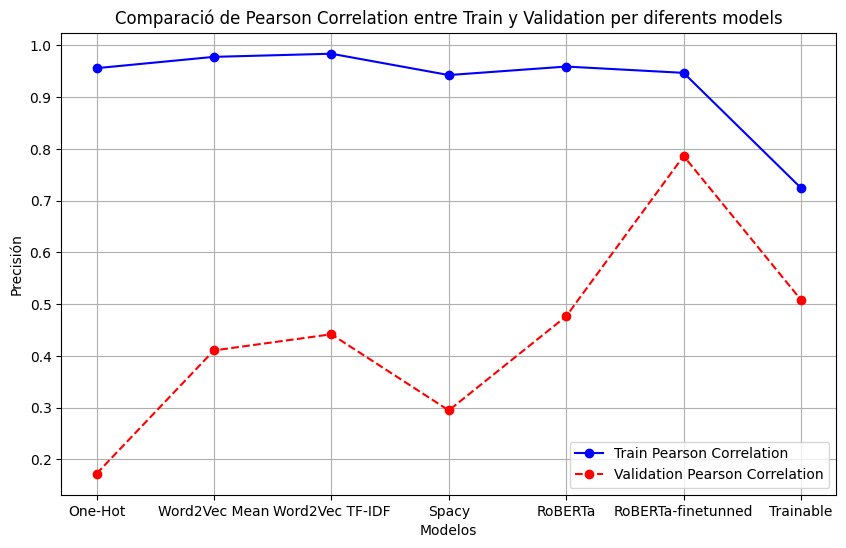

In [90]:
import matplotlib.pyplot as plt

models = ['One-Hot', 'Word2Vec Mean', 'Word2Vec TF-IDF', 'Spacy', 'RoBERTa', 'RoBERTa-finetunned', 'Trainable']
train_accuracies = [compute_pearson(model_oh, x_train_oh, y_train_oh), 
                    compute_pearson(model_w2v_mean, x_train_w2v_mean, y_train_w2v_mean),
                    compute_pearson(model_w2v_tfidf, x_train_w2v_tfidf, y_train_w2v_tfidf),
                    compute_pearson(model_sp, x_train_sp, y_train_sp),
                    compute_pearson(model_roberta, x_train_roberta, y_train_roberta),
                    compute_pearson_roberta_ft(predictions[:len(X_train_roberta_ft)], y_train_roberta_ft),
                    compute_pearson(model2, x_train_trainable, y_train_trainable)]
val_accuracies = [compute_pearson(model_oh, x_val_oh, y_val_oh),
                  compute_pearson(model_w2v_mean, x_val_w2v_mean, y_val_w2v_mean),
                  compute_pearson(model_w2v_tfidf, x_val_w2v_tfidf, y_val_w2v_tfidf),
                  compute_pearson(model_sp, x_val_sp, y_val_sp),
                  compute_pearson(model_roberta, x_val_roberta, y_val_roberta),
                  compute_pearson_roberta_ft(predictions[len(X_train_roberta_ft):len(X_train_roberta_ft) + len(X_val_roberta_ft)], y_val_roberta_ft),
                  compute_pearson(model2, x_val_trainable, y_val_trainable)]

# Crear el gráfico
plt.figure(figsize=(10, 6))
x = range(len(models))

plt.plot(x, train_accuracies, marker='o', linestyle='-', color='b', label='Train Pearson Correlation')
plt.plot(x, val_accuracies, marker='o', linestyle='--', color='r', label='Validation Pearson Correlation')

# Añadir etiquetas y título
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.title('Comparació de Pearson Correlation entre Train y Validation per diferents models')
plt.xticks(x, models)
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

## Conclusions

Com podem observar, tots els models fan overfit, per tant, no podem arribar a una conclusió sòlida respecte als models utilitzats. Si això no fos un estudi universitari hauríem d'invertir més temps a millorar els models perquè facin una millor generalització del problema.
Tot i això, arribem a la conclusió que el millor model de similitud de frases és el que té embeddings entrenables, seguit del model RoBERTa i del Tf-idf, ja que tots aquests tenen en compte totes les paraules de la frase de manera ponderada.

Aquests models són els que donen millor correlació de pearson en la partició de validació respecte a la partició d'entrenament així que són aquests els que generalitzen millor. Cal destacar que el model amb embedings Word2Vec entrenables és el millor, ja que no fa tant overfit i generalitza millor que la resta. En respecte dels models amb embeddings no entrenables, el millor és el de RoBERTa, que és bastant bo, però és més ineficient i no suporta la distància de cosinus com a mètrica de similitud.